# Neural Network

## Load Data

In [1]:
from timeit import default_timer as timer
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import helper
import numpy as np
import tensorflow as tf

In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 7:
Image - Min Value: 17 Max Value: 221
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


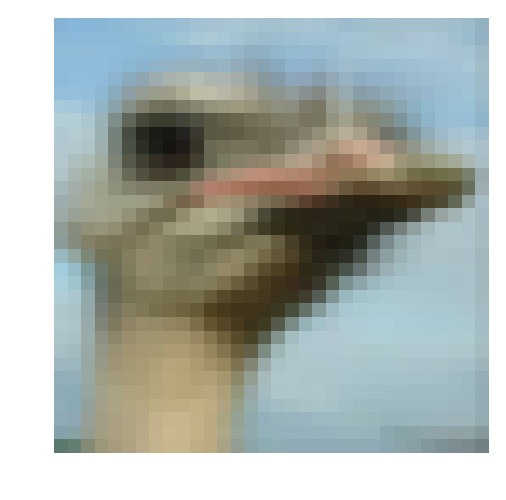

In [3]:
# Explore the dataset
batch_id = 4
sample_id = 7
batch_size = 5
image_sizes = 32
image_channels = 3
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Preprocess Data

In [4]:
def normalize(x):
    x_min = np.min(x)
    return (x - x_min)/(np.max(x) - x_min)

def one_hot_encode(x):
    encoder = tf.one_hot(x, 10)
    encodings = None
    with tf.Session() as sess:
        encodings = sess.run(encoder)
    return encodings

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Check Point

In [6]:
import pickle
import helper

# Load the Preprocessed Validation data for cifar-10
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [7]:
# load mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build Netwrok

In [8]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

In [9]:
class Network(object):
    
    def __init__(self, x_dim, n_classes):
        # Inputs
        self.init_placeholders(x_dim, n_classes)
        # Model
        self.logits = self.build()
        self.prediction = tf.nn.softmax(self.logits)
        # Loss and Optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y))
        # Accuracy
        correct_pred = tf.equal(tf.argmax(self.prediction, 1), self.y)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    def init_placeholders(self, x_dim, n_classes):
        self.x = tf.placeholder(tf.float32, [None, x_dim], name='x')
        self.y = tf.placeholder(tf.int64, [None], name='y')
        # dimension: batch_size, x
        self.l1_w = tf.placeholder(tf.float32, [None, None])
        self.l1_b = tf.placeholder(tf.float32, [None])
        self.l2_w = tf.placeholder(tf.float32, [None, None])
        self.l2_b = tf.placeholder(tf.float32, [None])

    def build(self):
        l1_a = tf.sigmoid(tf.nn.bias_add(tf.matmul(self.x, self.l1_w), self.l1_b))
        logits = tf.nn.bias_add(tf.matmul(l1_a, self.l2_w), self.l2_b)
        return logits

In [10]:
def print_stats(session, net, total_epochs, epoch, batch_i, feature_batch, label_batch):
    train_loss = session.run(net.cost, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_loss = session.run(net.cost, feed_dict={net.x:valid_features, net.y:valid_labels})
    train_accuracy = session.run(net.accuracy, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_accuracy = session.run(net.accuracy, feed_dict={net.x:valid_features, net.y:valid_labels})
    print('Epoch {:>2}/{:>2}, CIFAR-10 Batch {} | Train Acc: {:1.2} Loss: {:1.3} | Valid Acc: {:1.2} Loss: {:1.3}'.format(
        epoch, total_epochs, batch_i, train_accuracy, train_loss, valid_accuracy, valid_loss), end='\r')

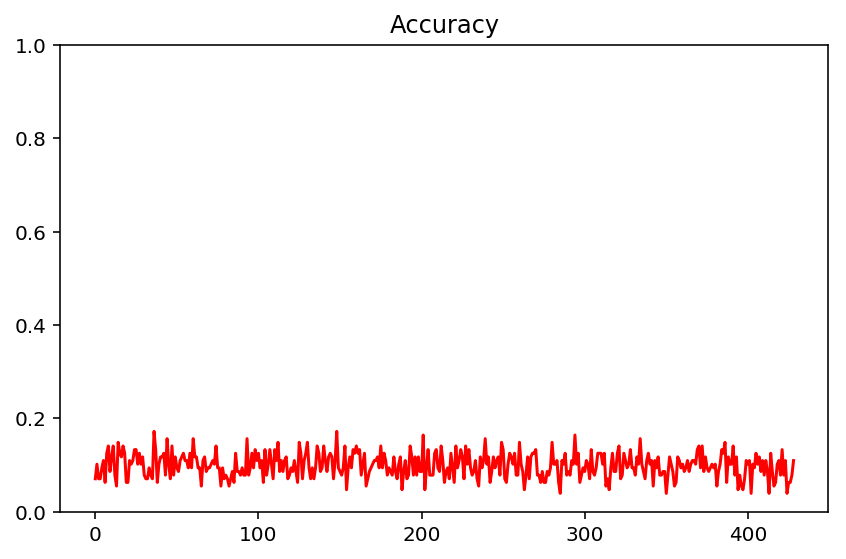

In [19]:
batch_size = 128
x_dim = 784
n_classes = 10

with tf.Session() as sess:
    
    net = Network(x_dim, n_classes)
    l1_w = np.random.rand(x_dim, 100)
    l1_b = np.random.rand(100)
    l2_w = np.random.rand(100, 1)
    l2_b = np.random.rand(1)

    accuracies = []
    # Initializing the variables
    batch_num = mnist.train.num_examples//batch_size
    for ii in range(batch_num):
        train_batch, labels = mnist.train.next_batch(batch_size)

        # Run optimizers
        feed_dict = {net.x:train_batch,
                     net.y:labels, 
                     net.l1_w:l1_w, 
                     net.l1_b:l1_b, 
                     net.l2_w:l2_w, 
                     net.l2_b:l2_b}
        logits, predict, accuracy = sess.run([net.logits, net.prediction, net.accuracy], feed_dict=feed_dict)
        accuracies.append(accuracy)
        
    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(batch_num), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()

# Genetic Algorithm

In [20]:
import numpy as np
from operator import attrgetter
import string
import random
import time

In [21]:
__DEBUG__ = False

In [42]:
batch_size = 64
x_dim = 784
n_classes = 10
train_batch, labels = mnist.train.next_batch(batch_size)

class Individual(object):
    
    def __init__(self, generation, gene={}):
        self.gene = gene
        self.score = -1
        self.evaluation_time = 0.0
        self.generation = generation
                
        # define penalties
        self.loss_mult = .1
        self.accuracy_mult = 3
        self.accuracy_delta_mult = 5
        self.penalty = 99999
        
        self.network_epochs = 5
        self.max_time = 30
        
        if gene == None:
            self.gene_length = 0
        else:
            self.gene_length = len(self.gene)
        
    def generate(self):
        # l1_w 
        self.gene[0] = np.random.randn(x_dim, 100)
        # l1_b 
        self.gene[1] = np.random.randn(100)
        # l2_w 
        self.gene[2] = np.random.randn(100, 1)
        # l2_b 
        self.gene[3] = np.random.randn(1)
        
    def fitness(self):
        self.score = 0
        
        if __DEBUG__:
            self.evaluation_time = np.random.random_sample()
            self.score = np.random.random_sample() + self.evaluation_time
            return
        
        tf.reset_default_graph()
        with tf.Session() as sess:
            # Run optimizers
            net = Network(x_dim, n_classes)
            feed_dict = {net.x: train_batch,
                         net.y: labels, 
                         net.l1_w: self.gene[0], 
                         net.l1_b: self.gene[1], 
                         net.l2_w: self.gene[2], 
                         net.l2_b: self.gene[3]}
            values = sess.run([net.accuracy], feed_dict=feed_dict)
            self.score = np.mean(values)

    def cross_over(self, parent):
        # TODO
        child = self.gene
        
        individ = Individual(generation=self.generation, gene=child)
        individ.generate()
        return individ
        
    def mutate(self, mutation_rate=0.01):
        # TODO
        pass
        

In [51]:
class Population(object):
    
    def __init__(self,
                 initial_population=200, 
                 max_generations=1000,
                 mutation_rate=0.01, 
                 elitism=True,
                 tournament_size=4,
                 solution_threshold=.9):
        self.initial_population = initial_population
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism = elitism
        self.tournament_size = tournament_size
        self.solution_threshold = solution_threshold
        self.time_elapsed = 0.0
        self.global_best_individual = None
        self.global_best_solution = 0.0
        self.current_best_individual = None
        self.current_best_solution = 0.0
        self.generation = 0
        self.population = []
        
    def _evaluate_fitnesses_(self):
        population_length = len(self.population)
        for i, p in enumerate(self.population):
            if p.score < 0:
                p.fitness()
                self.time_elapsed += p.evaluation_time
            print('{}/{}, Score {}, Time {}'.format(i+1, 
                                                     population_length, 
                                                     p.score,
                                                     p.evaluation_time))

        self.current_best_individual = self.evaluate_current_best_individual()
        self.current_best_solution = self.current_best_individual.score
        if self.global_best_individual == None or self.global_best_solution < self.current_best_solution:
            self.global_best_individual = self.current_best_individual
            self.global_best_solution = self.current_best_solution

    def _perform_tournament_selection_(self):
        tournament = Population()
        tournament.generation = self.generation
        for _ in range(self.tournament_size):
            i = random.choice(self.population)
            tournament.add_individual(i)
        return tournament.evaluate_current_best_individual()
    
    def generate(self):
        assert self.initial_population > 0
        self.population = [Individual(generation=self.generation) for _ in range(self.initial_population)]
        samples = np.random.sample(size=(self.initial_population, 784 * 100 * 100 * 100))
        print(samples[0])
        for p in self.population:
            p.generate()
    
    def evolve_generation(self):
        children_genes = []
        self._evaluate_fitnesses_()  
        
        if self.elitism:
            children_genes.append(self.current_best_individual)
            
        for _ in range(self.initial_population):
            # perform selection
            male = self._perform_tournament_selection_()
            female = self._perform_tournament_selection_()
            # perform cross-over
            new_individual = male.cross_over(female)
            new_individual.generation = self.generation
            # perform mutation
            new_individual.mutate(self.mutation_rate)
            children_genes.append(new_individual)
            
        self.population = children_genes
        self.generation += 1
            
    def evaluate_current_best_individual(self):
        return max(self.population, key=attrgetter('score'))
    
    def found_solution(self):
        return self.global_best_solution >= self.solution_threshold
    
    def add_individual(self, individual):
        self.population.append(individual)
    
    def print_score(self):
        if self.generation == 0:
            return
        print('Generation: {}/{}, Time {:2.2}s, Solution score: {}'.format(
            self.generation, 
            self.max_generations,
            self.global_best_individual.evaluation_time,
            self.global_best_solution))    

In [52]:
# hypter-parameters
max_generations = 5
population_size = 10
mutation_rate = 0.05

In [53]:
def execute(max_generations, population_size, mutation_rate, display_interval=1):
    population = Population(population_size, max_generations)
    population.generate()
    while not population.found_solution() and population.generation < max_generations:
        population.evolve_generation()
        if population.generation % display_interval == 0:
            population.print_score()
    best_individual = population.global_best_individual
    print('\nCompleted {} generations:\nFinal score: {}, Generation: {}'.format(
        population.generation, 
        best_individual.score, 
        best_individual.generation))

In [ ]:
execute(max_generations, population_size, mutation_rate)

## Train Network

In [26]:
tf.reset_default_graph()

# 92, 0.002, 0.8, 3, 64, 3, 32
# 256, 0.003, 0.6, 3, 92, 5, 64
# 64, 0.0005, 0.9, 3, 64, 4, 64
epochs = 10
batch_size = 64
learning_rate = 0.0005
keep_probability = .9
l1_kernel = 3
l1_depth = 64
l2_kernel = 4
l2_depth = 64

In [27]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    net = Network(l1_kernel=l1_kernel, 
                  l1_depth=l1_depth, 
                  l2_kernel=l2_kernel, 
                  l2_depth=l2_depth)
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                fd = {net.x:batch_features, net.y:batch_labels, net.keep_prob:keep_probability, net.learning_rate:learning_rate}
                sess.run(net.optimizer, feed_dict=fd)
            print_stats(sess, net, epochs, epoch + 1, batch_i, batch_features, batch_labels)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...


## Test Model

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6319665605095541



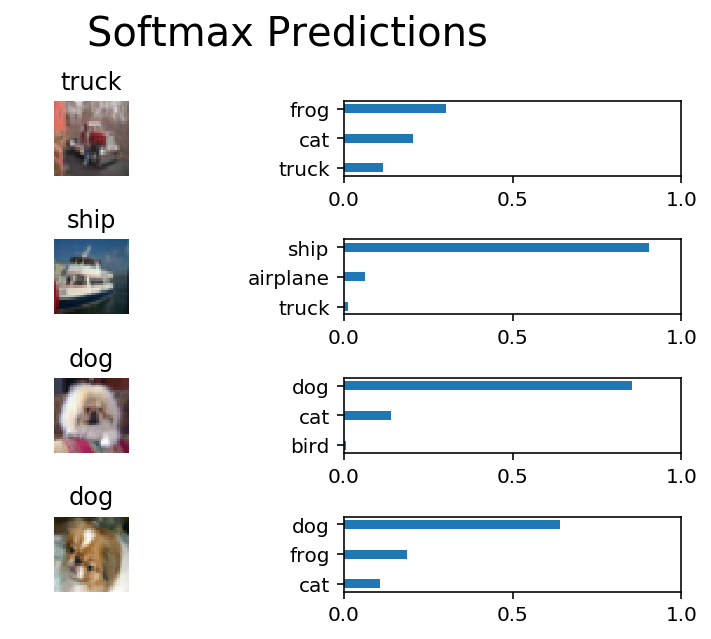

In [29]:
# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()